### Imports

In [34]:
from os.path import abspath, join
import pandas as pd
import numpy as np
import re
from mizani.formatters import percent_format
from plotnine import ggplot, geom_bar, aes, scale_x_discrete, theme, element_text, labs, ylim,\
    scale_x_continuous, scale_y_continuous, geom_line, geom_boxplot,  xlim, facet_wrap, scale_fill_manual

### Global constants
Files and paths

In [35]:
base_dir = "C:/Nitsan/third/JavaAnalyzer"
analyzer_results_file = "analyzerResults_v2.csv"
external_words_file = "analyzerResults_words_ALL.csv"

Graphs parameters

In [36]:
fill='#5a9cd9'
log_x_scale_labels = ["1", "2-10", "11-100", "101-1000", "1001-10000", "10001-100000"]

Column headers

In [37]:
name_col = "name"
length_col = "length"
project_col = "project"
type_col = "className"
word_count_col = "wordCount"
count_col = "count"
freq_col = "frequency"
rank_col = "rank"

## Data load

In [38]:
df = pd.read_csv(abspath(join(base_dir, analyzer_results_file)))

## Data cleanup:
1. Remove type declarations:

In [39]:
df = df[~df[type_col].isin(["TypeParameter","ClassOrInterfaceType"])]

2. Remove external words:

In [40]:
external_tagging_data = pd.read_csv(abspath(join(base_dir, external_words_file)))
external_words = external_tagging_data[np.where(external_tagging_data['external'] == 1, True, False)]['word']
df= df[~df[name_col].isin(external_words)]

Removed words:

In [41]:
print(external_words)

0                          T
1                     String
3                          R
4                     Object
8                  Throwable
9             requireNonNull
19               IOException
20                   Integer
29                     Class
30                      List
37                       com
61                      java
84                         K
88          serialVersionUID
89                         V
115          AtomicReference
116                     Long
118                 toString
123                      Map
129                     Type
170     InterruptedException
194               Collection
202                 Iterable
211              InputStream
220                ArrayList
222                     Math
241                      Set
275                   Arrays
279             OutputStream
283                  Boolean
308               AtomicLong
327              Collections
336     NullPointerException
338            AtomicInteger
430         Ru

### Dataframe preview:

In [42]:
print(df.sample(frac=1))

              project            name           className         role  length
411384  Signal-Server        register      MethodCallExpr    REFERENCE       8
360694     Playwright      connection            NameExpr    REFERENCE      10
84841         Jenkins        required     MemberValuePair  DECLARATION       8
370020     Playwright         timeout  VariableDeclarator  DECLARATION       7
26705            Gson  rawTypeAsClass            NameExpr    REFERENCE      14
...               ...             ...                 ...          ...     ...
220017        Jenkins     toHexString   MethodDeclaration  DECLARATION      11
17148         DBeaver  dialogInstance            NameExpr    REFERENCE      14
256213        Jenkins          LOGGER            NameExpr    REFERENCE       6
353783     Playwright     sendMessage      MethodCallExpr    REFERENCE      11
371758     Playwright            node            NameExpr    REFERENCE       4

[318243 rows x 5 columns]


## Histogram of 50 most common words in all projects together:

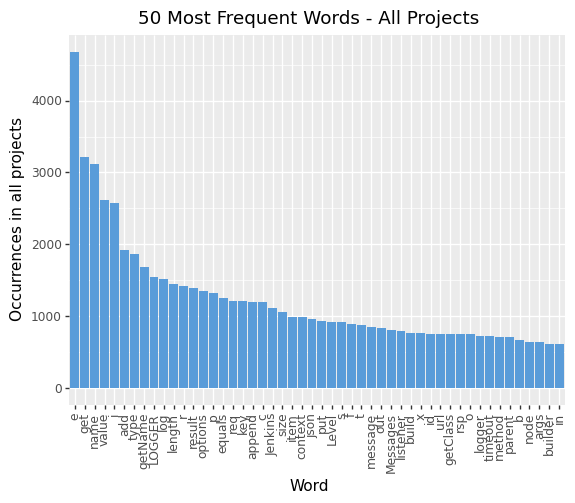

<ggplot: (113354963300)>


In [43]:
n = 50
word_occurrences_df = df.groupby([name_col, length_col])\
    .size()\
    .reset_index(name=count_col)\
    .sort_values(count_col, ascending=False)
word_occurrences_hist_df = word_occurrences_df.nlargest(n, count_col)

print(
	ggplot(word_occurrences_hist_df)
	+ labs(x="Word",
		   y="Occurrences in all projects",
		   title=str(n) + " Most Frequent Words - All Projects")
	+ scale_x_discrete(limits=word_occurrences_hist_df[name_col].tolist())
	+ geom_bar(aes(x=name_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Zipf's Law - Words rank / frequency in log scale:

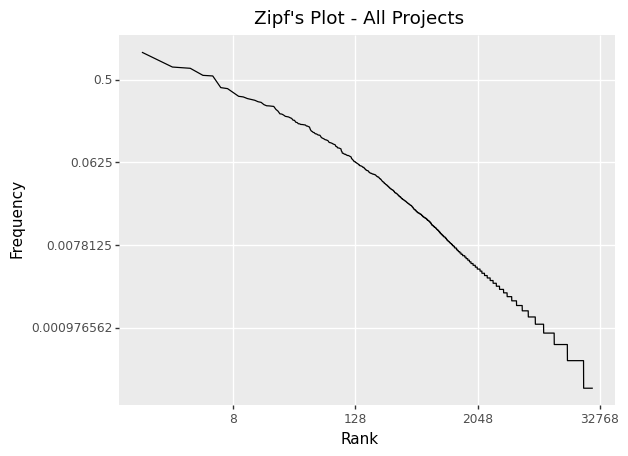

<ggplot: (113353639852)>


In [44]:
most_frequent_word_count = int(word_occurrences_df[:1][count_col])

# Add new normalized "frequency" column
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_count
word_occurrences_df_length = word_occurrences_df.shape[0]
word_occurrences_df[rank_col] = np.linspace(1, word_occurrences_df_length, word_occurrences_df_length)

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


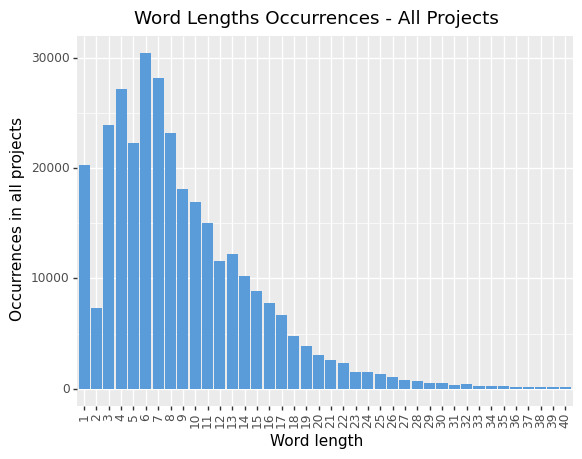

<ggplot: (113353252596)>


In [45]:
n = 40
length_occurrences_df = df.groupby([length_col]).size().reset_index(name=count_col)
length_occurrences_hist_df = length_occurrences_df.nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Add words rank per project

In [46]:
word_occurrences_per_project_df = df.groupby([name_col, length_col, project_col])\
    .size() \
    .reset_index(name=count_col) \
    .sort_values(count_col, ascending=False)

# Add rank column per project
# At the end of this process, we will have N rows in our dataframe with rank k,
# where N is the total number of project
projects = []
for project in word_occurrences_per_project_df[project_col].unique():
    project_df = word_occurrences_per_project_df[word_occurrences_per_project_df[project_col] == project]
    project_df.reset_index().sort_values(count_col, ascending=False)
    project_df_size = project_df.shape[0]
    project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)
    projects.append(project_df)

all_projects_df = pd.concat(projects)

# Calculate how many rank bins we'll need, cut the dataframe accordingly
bin_count = int(np.ceil(np.math.log(all_projects_df["project_rank"].max())))
all_projects_df["project_rank_bin"] = pd.cut(all_projects_df["project_rank"],
                                             bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

<ipython-input-46-747aced00e7e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df['project_rank'] = np.linspace(1, project_df_size, project_df_size)


## Words' lengths by rank - per project breakdown

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


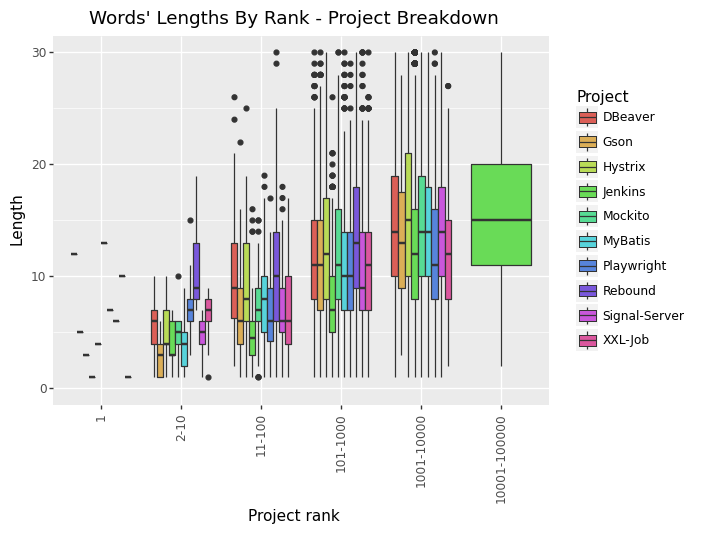

<ggplot: (113353635497)>


In [47]:
print(
    ggplot(all_projects_df)
    + labs(y="Length",
           x="Project rank",
           title="Words' Lengths By Rank - Project Breakdown",
           fill="Project")
    + geom_boxplot(aes(x='project_rank_bin', y=length_col, fill=project_col), position="dodge")
    + ylim(0, 30)
    + scale_x_discrete(limits=all_projects_df["project_rank_bin"].unique(), labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
      )

## Words' lengths by rank - all projects together

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


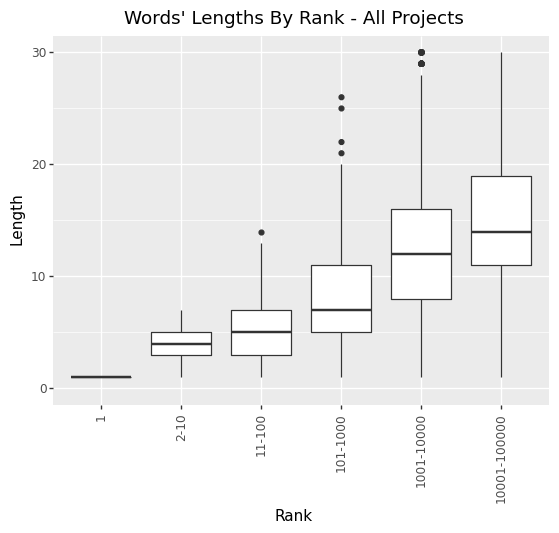

<ggplot: (113353046899)>


In [48]:
bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col], bins=[0]+list(np.logspace(0, bin_count, bin_count+1)))

print(ggplot(word_occurrences_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90))
      )

## Compound Words - split and  count
### Define splitting function - by camelCase / PascalCase / snake_case:

In [49]:
def split_identifier_and_count(inpt):
	if inpt is None:
		return 0
	return len(re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[_A-Z]*(?=[_A-Z]|$))', str(inpt)))

# Make sure the count is correct for different cases:
assert split_identifier_and_count("UUIDa") == 2
assert split_identifier_and_count("_hello") == 1
assert split_identifier_and_count("well_hello") == 2
assert split_identifier_and_count("howDoYouDo") == 4
assert split_identifier_and_count("HowDoYouDo") == 4
assert split_identifier_and_count("okTTYLbye") == 3

### Split all names and add word count column:

In [50]:
word_occurrences_df[word_count_col] = word_occurrences_df[name_col]\
    .apply(split_identifier_and_count)\
    .astype('category')

word_occurrences_per_project_df = word_occurrences_per_project_df.merge(
    word_occurrences_df[[name_col, word_count_col]],
    on=name_col,
    how='left'
)

## Identifiers' lengths frequency with word count breakdown for all project combined:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 47 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


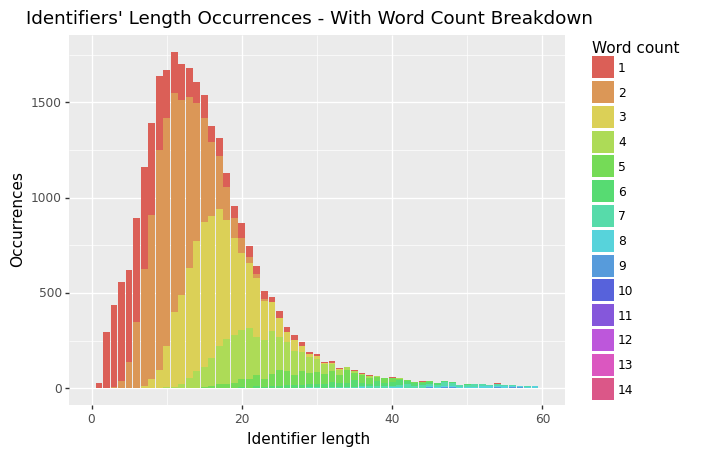

<ggplot: (113353048311)>


In [51]:
print(
	ggplot(word_occurrences_df)
	+ labs(x="Identifier length",
		   y="Occurrences",
		   title="Identifiers' Length Occurrences - With Word Count Breakdown",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
  	+ xlim(0, 60)
)

## Identifiers lengths frequency, with word count breakdown - per project:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_count : Removed 889 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_bar : Removed 25 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


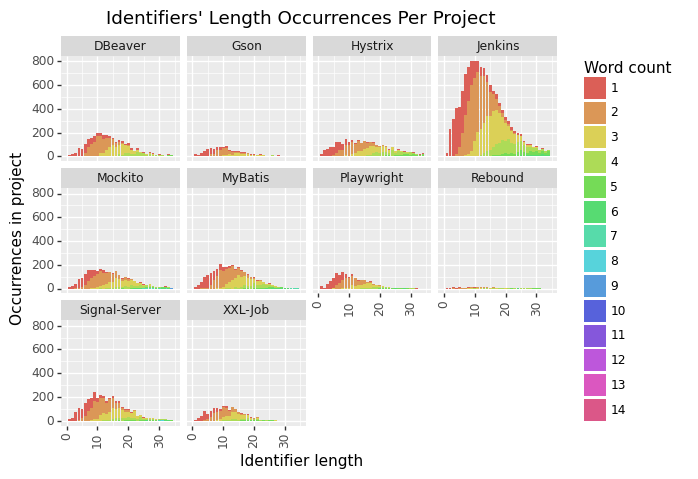

<ggplot: (113353660031)>


In [52]:
print(
	ggplot(word_occurrences_per_project_df)
	+ labs(x="Identifier length",
		   y="Occurrences in project",
		   title="Identifiers' Length Occurrences Per Project",
           fill="Word count")
	+ geom_bar(aes(x=length_col, fill=word_count_col))
  	+ xlim(0, 35)
	+ facet_wrap(project_col)
	+ theme(axis_text_x=element_text(rotation=90))
)



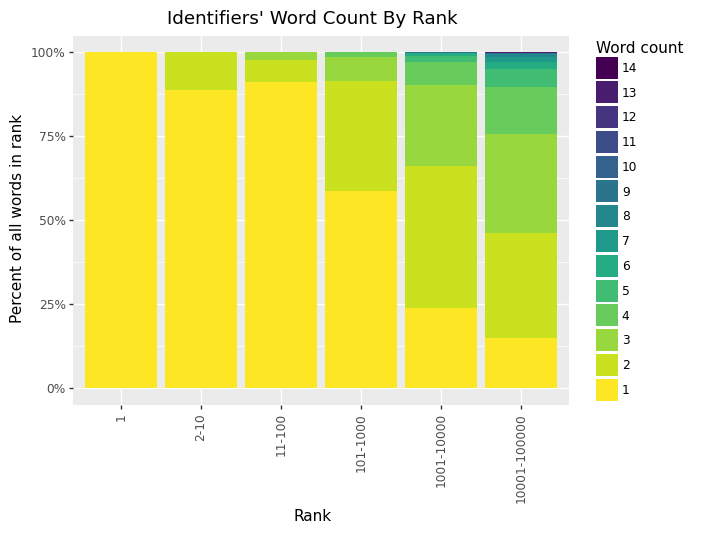

<ggplot: (113353724660)>


In [53]:
word_occurrences_df[word_count_col] = pd.Categorical(word_occurrences_df[word_count_col],
                                             categories=list(range(14, 0, -1)),
                                             ordered=True)

most_frequent_word_occurrences = int(word_occurrences_df[:1][count_col])
data_length = word_occurrences_df.shape[0]
word_occurrences_df[freq_col] = word_occurrences_df[count_col] / most_frequent_word_occurrences
word_occurrences_df[rank_col] = np.linspace(1, data_length, data_length)

bin_count = int(np.ceil(np.math.log(word_occurrences_df.shape[0])))
word_occurrences_df["rank_bin"] = pd.cut(word_occurrences_df[rank_col],
									bins=[0] + list(np.logspace(0, bin_count, bin_count + 1)))

print(
    ggplot(word_occurrences_df)
    + labs(x="Rank",
		   y="Percent of all words in rank",
		   title="Identifiers' Word Count By Rank",
           fill="Word count")
    + geom_bar(aes(x='rank_bin', fill=word_count_col), position="fill")
    + scale_y_continuous(labels=percent_format())
    + scale_x_discrete(labels=log_x_scale_labels)
    + theme(axis_text_x=element_text(rotation=90))
)

# Regenerating all the graphs after splitting compound words
## Setup splitting function:

In [54]:
def split_identifier_and_append_to_df(inpt):
    if inpt is None:
        return 0
    parts = re.findall(r'_?[A-Za-z_](?:[a-z0-9]+|[_A-Z]*(?=[_A-Z]|$))', str(inpt))
    if len(parts) > 1:
        for part in parts:
            plain_part = part.lower().replace("_", "")
            if plain_part in split_words:
                split_words[plain_part] += 1
            else:
                split_words[plain_part] = 1

split_words = {}
word_occurrences_df[name_col].apply(split_identifier_and_append_to_df)
split_words_df = pd.DataFrame(split_words.items(), columns=[name_col, count_col])

Words + count that will be added to original data:

In [55]:
print(split_words_df)

           name  count
0           get   3410
1          name    740
2         class    340
3        logger     42
4            is    854
...         ...    ...
4034      c2396      1
4035    encrypt      1
4036        hot      1
4037  privilege      1
4038   loadable      1

[4039 rows x 2 columns]


In [56]:
split_words_df[length_col] = split_words_df[name_col].str.len()
split_words_df = pd.concat([word_occurrences_df, split_words_df]).groupby([name_col, length_col])[count_col]\
    .sum()\
    .reset_index()\
    .sort_values(count_col, ascending=False)

Data after adding split words:

In [57]:
print(split_words_df)

                                   name  length  count
14390                               get       3   6628
12801                                 e       1   4674
21678                              name       4   3858
29411                             value       5   2883
18371                                 i       1   2602
...                                 ...     ...    ...
16530              getParameterMapNames      20      1
16532                  getParameterMaps      16      1
16536                  getParameterSpec      16      1
1962   DispatcherDefaultingToRealMethod      32      1
30268                            zscore       6      1

[30269 rows x 3 columns]


### Words frequencies - Zipf's plot:

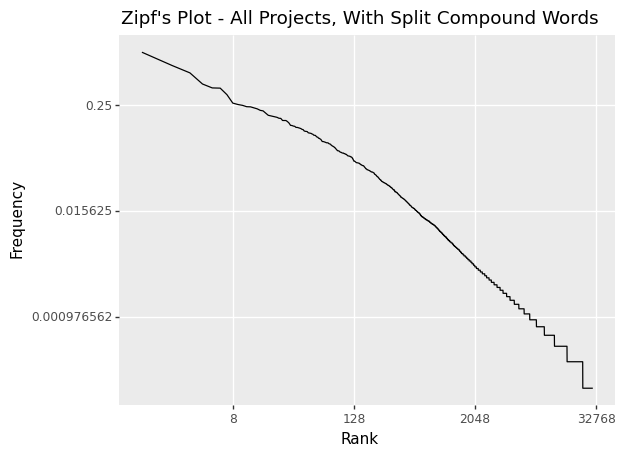

<ggplot: (113354453050)>


In [58]:
split_words_df[freq_col] = split_words_df[count_col] / int(split_words_df[:1][count_col])
split_words_df_length = split_words_df.shape[0]
split_words_df[rank_col] = np.linspace(1, split_words_df_length, split_words_df_length)

print(
    ggplot(split_words_df)
    + labs(x="Rank",
           y="Frequency",
           title="Zipf's Plot - All Projects, With Split Compound Words")
    + scale_x_continuous(trans='log2')
    + scale_y_continuous(trans='log2')
    + geom_line(aes(x=rank_col, y=freq_col), stat='identity')
)


### Words lengths occurrences:

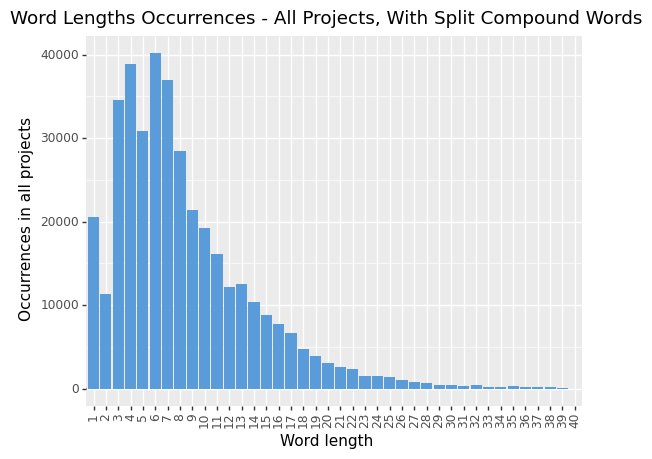

<ggplot: (113353592299)>


In [59]:
n = 40
length_occurrences_hist_df_with_split_words = split_words_df.groupby(length_col)[count_col]\
    .sum()\
    .reset_index()\
    .nsmallest(n, length_col)

print(
	ggplot(length_occurrences_hist_df_with_split_words)
	+ labs(x="Word length",
		   y="Occurrences in all projects",
		   title="Word Lengths Occurrences - All Projects, With Split Compound Words")
	+ scale_x_discrete(limits=range(1, 41))
	+ geom_bar(aes(x=length_col, y=count_col), fill=fill, stat='identity')
	+ theme(axis_text_x=element_text(rotation=90))
)

### Words' lengths by rank - all projects together:

c:\users\alich\appdata\local\programs\python\python38\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_boxplot : Removed 1486 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


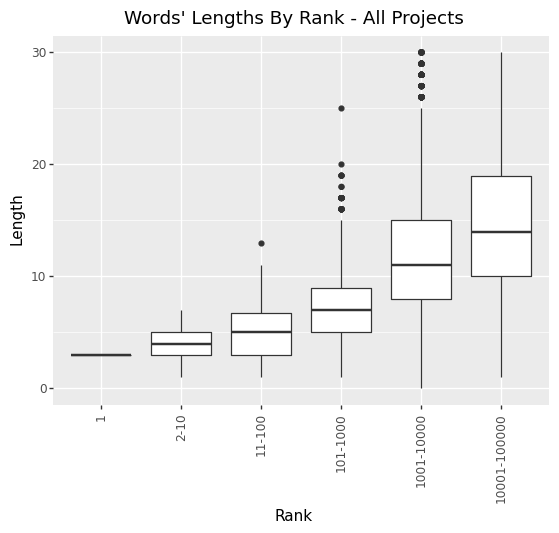

<ggplot: (113354138381)>


In [60]:
split_bin_count = int(np.ceil(np.math.log(split_words_df.shape[0])))
split_words_df["rank_bin"] = pd.cut(split_words_df[rank_col],
                                         bins=[0]+list(np.logspace(0, split_bin_count, split_bin_count+1)))

print(ggplot(split_words_df)
      + labs(y="Length",
             x="Rank",
             title="Words' Lengths By Rank - All Projects")
      + geom_boxplot(aes(x='rank_bin', y=length_col))
      + ylim(0, 30)
      + scale_x_discrete(labels=log_x_scale_labels)
      + theme(axis_text_x=element_text(rotation=90))
      )
